In [2]:
import numpy as np
import scipy as sp
import pandas as pd
from utils import *
from matplotlib import pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2

# Logistic Regression

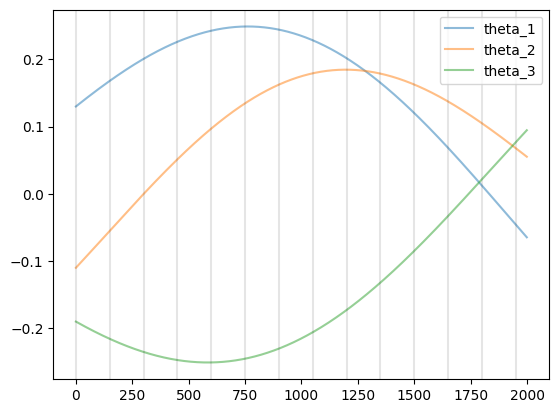

In [107]:
np.random.seed(5)

T = 2000
d = 3
# four = RandomFourier(d=d, T=T, k_fouier=10, sigma=.1)
# X, y, thetas = four.gen(T)

a = np.array([.17, .23, -.12])[:, None]
b = np.array([.13, -.11, -.19])[:, None]
P_1 = 4000
P_2 = 6000
t = np.arange(T)
thetas = a * np.sin((2 * np.pi * t)/ P_1) + b * np.cos((2 * np.pi * t)/ P_2)

thetas = thetas.T

d = 3
sigma = .1
X = np.random.randn(T,d)
y = (X * thetas).sum(axis=1) + np.random.randn(T) * sigma
y = (y >= 0).astype(int)

H = 150
gamma = (1/2) ** (1/H)
alpha=1

log_ful = Logistic_tail(H=T, gamma=gamma, alpha=alpha, name="Logistic_full") 
log_horizon = Logistic_tail(H=H, gamma=gamma, alpha=alpha)


for i in range(d):
    plt.plot(thetas[:, i], label="theta_{}".format(i+1), alpha = .5)
    
for i in range(0, T, H):
    plt.axvline(i, color="black", alpha=.1)

plt.legend()
# plt.savefig("figures/logistic_theta.pdf")


In [108]:
eval = Evaluator([log_ful, log_horizon], X, y, thetas)
results = eval.evaluate()

evaluating  Logistic_full


  0%|          | 0/1999 [00:00<?, ?it/s]

100%|██████████| 1999/1999 [01:44<00:00, 19.04it/s]


evaluating  Logistic_tail


100%|██████████| 1999/1999 [00:30<00:00, 64.82it/s]


Text(0, 0.5, 'Accuracy')

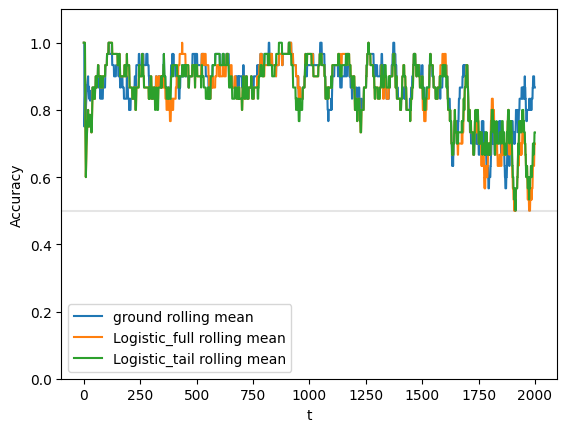

In [109]:
roll = 30

out = results["ground"]
correct = np.isclose(out,y)
correct = pd.Series(correct).rolling(roll, min_periods=0).mean()
plt.plot(np.arange(len(correct)), correct, label="ground rolling mean")

out_logistic, times_logistic, thetas_logistic = results["Logistic_full"]
correct_logistic = np.isclose(out_logistic,y)
log_roll = pd.Series(correct_logistic).rolling(roll, min_periods=0).mean()
plt.plot(np.arange(len(log_roll)), log_roll, label="Logistic_full rolling mean")


out_logistic_tail, times_logistic_tail, thetas_logistic_tail = results["Logistic_tail"]
correct_logistic_tail = np.isclose(out_logistic_tail,y)
log_tail_roll = pd.Series(correct_logistic_tail).rolling(roll, min_periods=0).mean()
plt.plot(np.arange(len(log_tail_roll)), log_tail_roll, label="Logistic_tail rolling mean")


plt.ylim(0,1.1)
plt.legend()

# plot a vertical grey line alpha=.2 every 100 steps on the x axis
# for i in range(0, len(correct), dur):
#     plt.axvline(i, color='grey', alpha=.2)

# plot a line at y = .5
plt.axhline(.5, color='grey', alpha=.2)

plt.xlabel("t")
plt.ylabel("Accuracy")
# plt.title("Rolling classification accuracy")

# plt.savefig("figures/logistic.pdf")


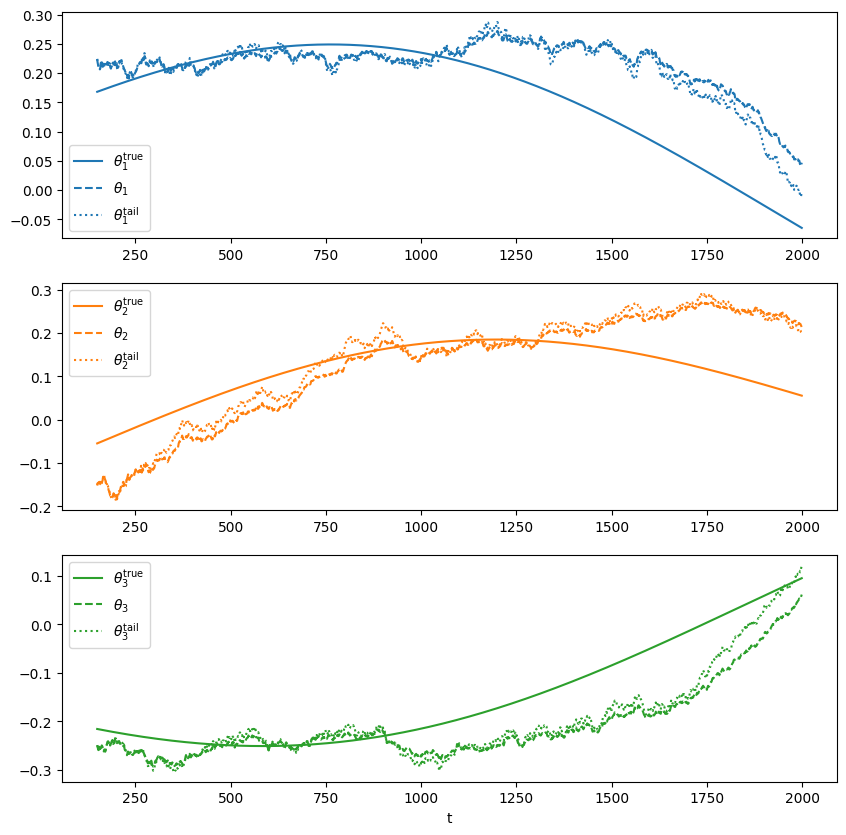

In [110]:
c = plt.get_cmap('tab10')
fig, axs = plt.subplots(d, 1, figsize=(10, 10))
for i in range(d):
    t = np.arange(H, T)
    plt.sca(axs[i])
    plt.plot(t,thetas[H:, i], label=r"$\theta_{{{}}}^{{\text{{true}}}}$".format(i+1), color=c(i))
    plt.plot(t,thetas_logistic[H:, i], label=r"$\theta_{{{}}}$".format(i+1), color=c(i), linestyle="--")
    plt.plot(t,thetas_logistic_tail[H:, i], label=r"$\theta_{{{}}}^{{\text{{tail}}}}$".format(i+1), color=c(i), linestyle=":")
    plt.legend()

plt.xlabel("t")
plt.savefig("../ewmm/figures/logistic_theta_fit.pdf")

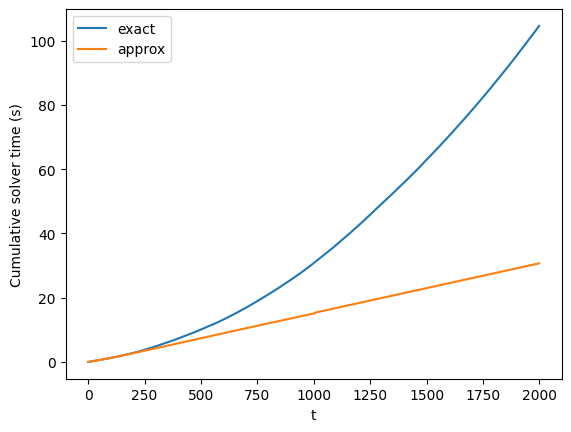

In [111]:
plt.plot(np.cumsum(times_logistic), label="exact")
plt.plot(np.cumsum(times_logistic_tail), label="approx")
plt.legend()
plt.xlabel("t")
plt.ylabel("Cumulative solver time (s)")
plt.savefig("../ewmm/figures/logistic_time.pdf")

# Quantile estimation

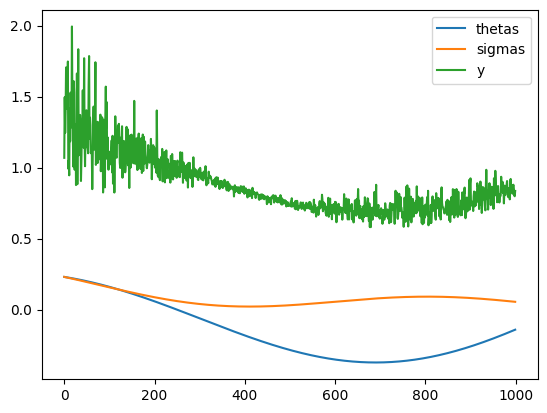

In [148]:
sigma_sample = .2
np.random.seed(13)

T = 1000
d = 1
# four = RandomFourier(d=d, T=T, k_fouier=10, sigma=.1)
# _, _, thetas = four.gen(T)
# thetas = thetas[:, 0]

a = np.array([-.17])
b = np.array([.23])
c = np.array([-.12])
d = np.array([.13])
P_1 = 2100
P_2 = 1500
P_3 = 1100
P_4 = 1700
t = np.arange(T)
thetas = a * np.sin((2 * np.pi * t)/ P_1) + b * np.cos((2 * np.pi * t)/ P_2)
sigmas = c * np.sin((2 * np.pi * t)/ P_3) + d * np.cos((2 * np.pi * t)/ P_4) + .1

y = sp.stats.lognorm.rvs(s=sigmas, scale=np.exp(thetas))
# y = np.random.randn(T) * sigmas + thetas

plt.plot(thetas, label="thetas")
plt.plot(sigmas, label="sigmas")
plt.plot(y, label="y")
plt.legend()

H = 70
gamma = (1/2) ** (1/H)
models = []
for alpha in [.15,.5,.85]:
    qest = QuantileEstimator(alpha, gamma)
    qest_tail = QuantileEstimator(alpha, gamma, tail_approx = 100)
    qest_tail_grad = QuantileEstimator(alpha, gamma, tail_approx = 100, grad=True)
    models.append(qest)
    models.append(qest_tail)
    models.append(qest_tail_grad)

In [149]:
eval = Evaluator(models, None, y, thetas)
# eval = Evaluator(models[-1:], None, y, thetas)
results = eval.evaluate()

evaluating  alpha=0.15
alpha=0.15


  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:07<00:00, 142.62it/s]


evaluating  alpha=0.15_tail_approx
alpha=0.15_tail_approx


 10%|▉         | 96/999 [00:00<00:02, 303.48it/s]/Users/ericluxenberg/.pyenv/versions/3.9.18/lib/python3.9/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 999/999 [00:05<00:00, 175.49it/s]


evaluating  alpha=0.15_tail_approx_grad
alpha=0.15_tail_approx_grad


100%|██████████| 999/999 [00:17<00:00, 58.40it/s] 


evaluating  alpha=0.5
alpha=0.5


100%|██████████| 999/999 [00:06<00:00, 156.57it/s]


evaluating  alpha=0.5_tail_approx
alpha=0.5_tail_approx


100%|██████████| 999/999 [00:05<00:00, 197.53it/s]


evaluating  alpha=0.5_tail_approx_grad
alpha=0.5_tail_approx_grad


100%|██████████| 999/999 [00:16<00:00, 59.41it/s] 


evaluating  alpha=0.85
alpha=0.85


100%|██████████| 999/999 [00:07<00:00, 128.89it/s]


evaluating  alpha=0.85_tail_approx
alpha=0.85_tail_approx


100%|██████████| 999/999 [00:05<00:00, 192.78it/s]


evaluating  alpha=0.85_tail_approx_grad
alpha=0.85_tail_approx_grad


100%|██████████| 999/999 [00:16<00:00, 59.11it/s] 


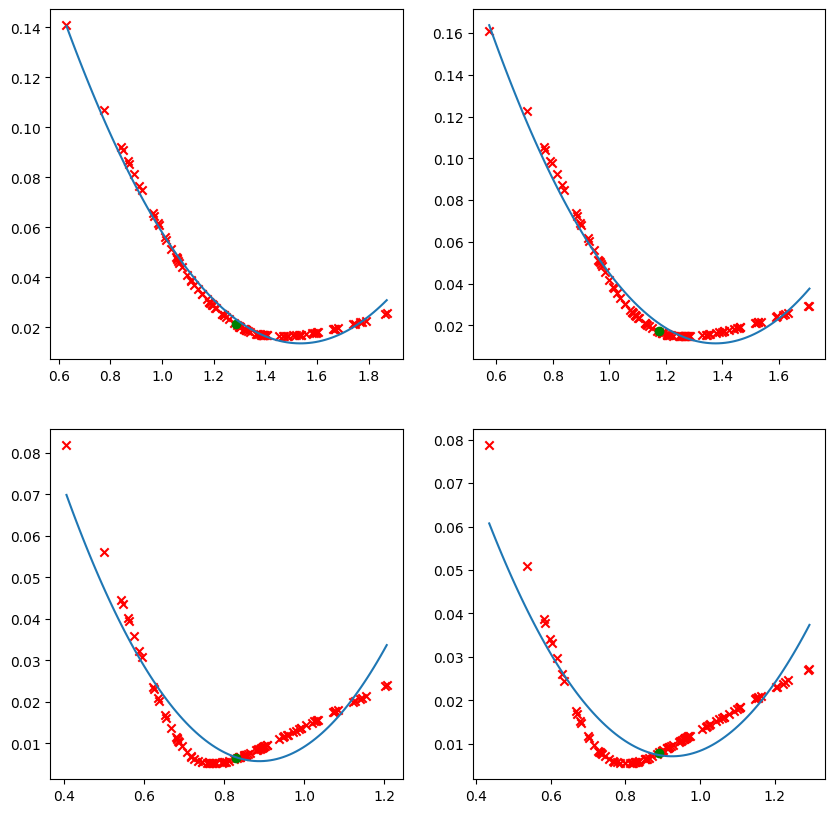

In [155]:
D = models[-1].plot_data
D = [D[0], D[1], D[-2], D[-1]]
n = len(D)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, d in enumerate(D):
    x,y,z, p, prev, f_prev = d
    plt.sca(axs[i//2, i%2])
    plt.scatter(x, y, marker="x", color="red", label="tail loss evaluations")
    plt.plot(z, p, label="tail fit")
    plt.scatter(prev, f_prev, color="green", label="previous estimate")

plt.savefig("../ewmm/figures/quantile_tail_fit.pdf")

    
    




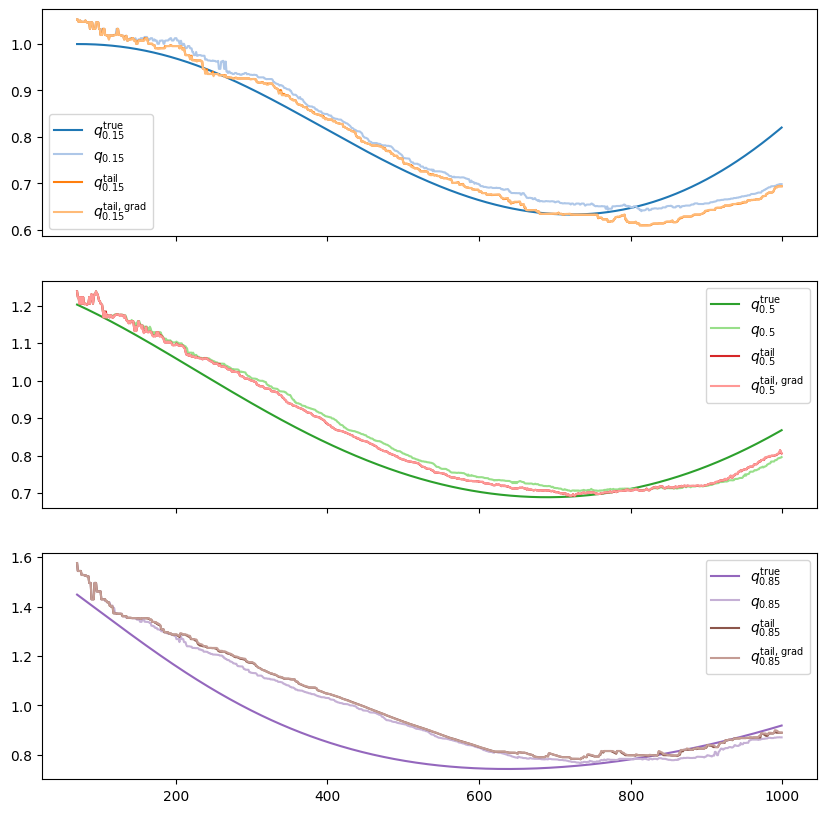

In [153]:
i = 0

# use color map tab20b 
colors = plt.get_cmap('tab20')

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
for alpha in [.15,.5,.85]:
    # true_q = sp.stats.norm.ppf(alpha, loc=thetas, scale=sigmas)

    # get the alpha quantile of a log normal distribution with mean theta and
    # standard deviation sigma_sample
    true_q = sp.stats.lognorm.ppf(alpha, s=sigmas, scale=np.exp(thetas))

    preds_full, times_full = results[f"alpha={alpha}"]
    preds_tail, times_tail = results[f"alpha={alpha}_tail_approx"]
    preds_tail_grad, times_tail_grad = results[f"alpha={alpha}_tail_approx_grad"]

    t = np.arange(H, T)    
    plt.sca(axs[i])
    
    c = 4*i

    plt.plot(t, true_q[H:], label=r"$q_{{{}}}^{{\text{{true}}}}$".format(alpha), color = colors(c))
    plt.plot(t, preds_full[H:], label=r"$q_{{{}}}$".format(alpha), color = colors(c+1))
    plt.plot(t, preds_tail[H:], label=r"$q_{{{}}}^{{\text{{tail}}}}$".format(alpha), color = colors(c+2))
    plt.plot(t, preds_tail_grad[H:], label=r"$q_{{{}}}^{{\text{{tail, grad}}}}$".format(alpha), color = colors(c+3))
    plt.legend()
    i += 1

plt.savefig("../ewmm/figures/quantile.pdf")

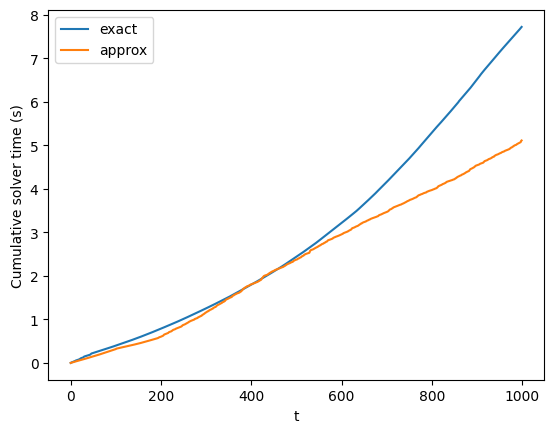

In [152]:
# plot the cumulative solver time for the tail approximator and the full
# quantile estimator
plt.plot(np.cumsum(times_full), label="exact")
plt.plot(np.cumsum(times_tail), label="approx")
plt.legend()
plt.xlabel("t")
plt.ylabel("Cumulative solver time (s)")
plt.savefig("../ewmm/figures/quantile_time.pdf")

# Sparse inverse covariance estimation

In [2]:


df = pd.read_csv("data/10_Industry_Portfolios_Daily.csv")
df.rename(columns={"Unnamed: 0": "date"}, inplace=True)
df.index = pd.to_datetime(df["date"], format="%Y%m%d")
# drop the date column
df = df.drop(columns=["date"])

# Missing data are indicated by -99.99 or -999. Drop these rows
df = df.replace(-99.99, np.nan)
df = df.replace(-999, np.nan)
# drop rows with missing data
df = df.dropna()
# restrict to the last 4 years
df = df[df.index > "2020-01-01"]

In [15]:
# Form the models

H = 63
sics = [
    SparseInverseCov(
        name = "SIC_{}".format(lam),
        lam = lam,
        beta = (1/2) ** (1/H)
    )
    for lam in [2.5,5,7.5,10]
]

sic_dumb = SparseInverseCovDumb(
    name = "SIC_dumb",
    lam = 2.5,
    beta = (1/2) ** (1/H)
)


X = df.values

# eval = Evaluator(sics, None, X, None)
eval = Evaluator([sics[0],sic_dumb], None, X[:100], None)
results = eval.evaluate()

evaluating  SIC_2.5


100%|██████████| 90/90 [00:02<00:00, 31.50it/s]


evaluating  SIC_dumb


100%|██████████| 90/90 [13:34<00:00,  9.04s/it]


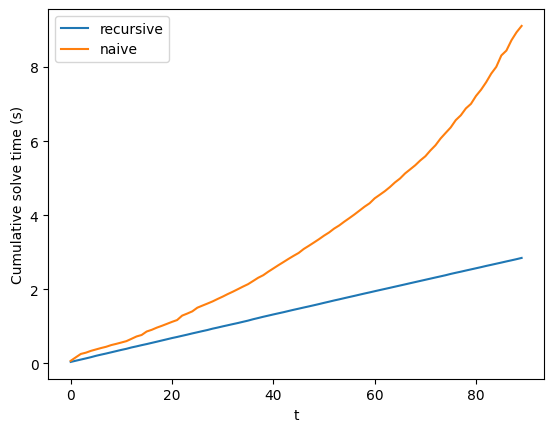

In [16]:
times_fast = results["SIC_2.5"][1]
times_slow = results["SIC_dumb"][1]
plt.plot(np.cumsum(times_fast), label="recursive")
plt.plot(np.cumsum(times_slow), label="naive")
plt.xlabel("t")
plt.ylabel("Cumulative solve time (s)")
plt.legend()
plt.savefig("figures/cov_time.pdf")


In [480]:
def sparsity(A):
    Az = np.abs(A) > .001
    # get lower tringular indices
    tril = np.tril_indices_from(Az, k=-1)
    return Az[tril].sum()

[35.905604719764014, 33.90462143559488, 29.661750245821043, 23.941002949852507]


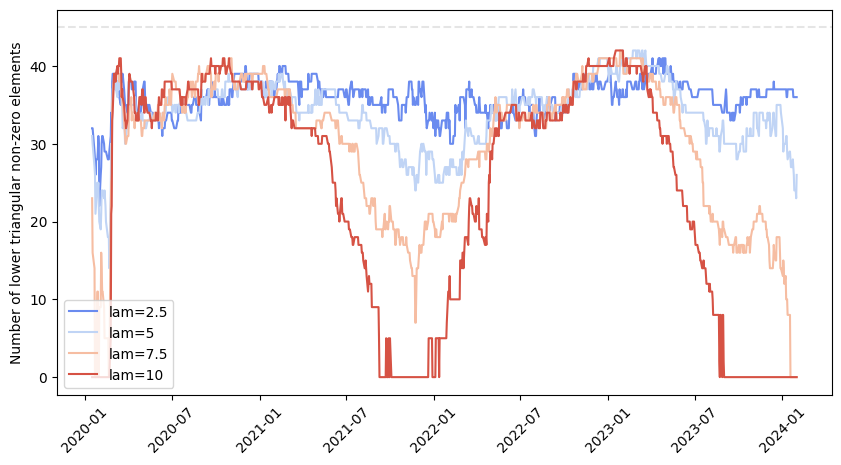

In [481]:
dt = df.iloc[10:].index

c = plt.get_cmap('coolwarm')
avgs = []
for k, v in results.items():
    nz = [sparsity(a) for a in v[0]]
    label="lam="+k[4:]
    avgs += [np.mean(nz)]
    plt.plot(dt, nz,label=label, color=c((float(k[4:])-1)/10))


# plot a line at y = d(d-1)/2 - d for d=10
plt.axhline(10*9/2, color='grey', alpha=.2, linestyle="--")

plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Number of lower triangular non-zero elements")
plt.gcf().set_size_inches(10, 5)

plt.savefig("figures/sic_sparsity.pdf")
print(avgs)

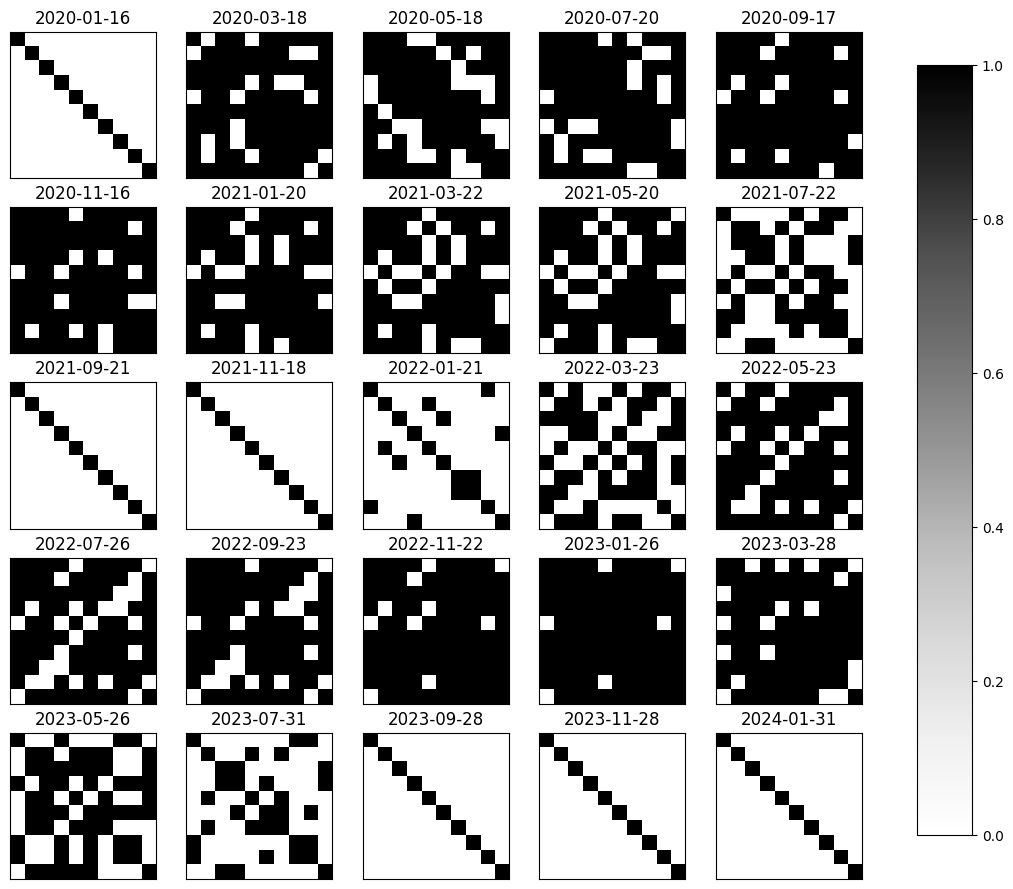

In [500]:
preds = results["SIC_10"][0]
inds = np.linspace(0, len(preds)-1, 25).astype(int)
fig, axs = plt.subplots(5, 5, figsize=(11, 11))
i = 0
for theta in preds[inds]:
    ax = axs[i // 5, i % 5]  # Get the current axes
    theta_ = theta.copy()
    theta_ = np.abs(theta_) > .001
    im = ax.imshow(theta_, cmap="Greys")  # Save the output of imshow
    ax.set_title("{}".format(df.iloc[10:].index[inds[i]])[:10])
    i += 1
    ax.set_xticks([])
    ax.set_yticks([])

# Create a new axes on the right side of the figure for the colorbar
cbar_ax = fig.add_axes([.95, 0.15, 0.05, 0.7])
# Add the colorbar to the new axes
fig.colorbar(im, cax=cbar_ax)  # Pass the output of imshow to colorbar

plt.savefig("figures/sic.pdf", bbox_inches='tight')